In [215]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [216]:
from google.colab import drive, files
drive.mount('/content/drive')
rootpath = '/content/drive/Shareddrives/KW phase1 repo'
import sys
sys.path.append(rootpath+'/package')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [217]:
import sys
sys.path.append(rootpath+'/package')
from utils.env_sdp_realRSS import env
import pickle
import numpy as np
import csv
import cvxpy as cp

from model.uav import UAV, setUAVEnv
from model.sdpv3 import SDP, setSDPEnv
# from model.realData_indoor_sdpv3 import calculateSDP, SDP, setSDPEnv
from model.pathlossmodel import PathLossModel, NoiseMaker, setPathLossModelEnv

from service.distributeuavs import createUAVsSamples,setDistributeUavsEnv , TestEnv
from service.measurerss import measureRSS, setMeasuerRssEnv
from service.combinationset import combinationSet , setCombinationSetEnv
from multiprocessing import Pool

setDistributeUavsEnv("sdp_realRSS")
TestEnv()
setCombinationSetEnv("sdp_realRSS")
setPathLossModelEnv("sdp_realRSS")
setMeasuerRssEnv("sdp_realRSS")
setUAVEnv("sdp_realRSS")
setSDPEnv("sdp_realRSS")

envName sdp_realRSS
11


In [218]:
pick =2
model="VAE"

In [219]:
collinearSample = 21

### Read final anomaly detection results

In [220]:
import pickle as dill
_UAVsSamples = {}
iSample = 0
with open(rootpath+"/datas/anomalySDPResult"+"/0906_realRSS_10-26/UAVsSamples_pick{}_300.npy".format(pick), 'rb') as f:
  while True:
    if iSample >= env.LOAD_SAMPLES_FOR_AE:
       break
    try:
      _UAVsSamples[iSample] = dill.load(f)
      iSample += 1
    except EOFError:
      break
UAVsSamples = _UAVsSamples
print(UAVsSamples)

{0: {'ESP01': <model.uav.UAV object at 0x7f5886ed23d0>, 'ESP02': <model.uav.UAV object at 0x7f5886ede790>, 'ESP03': <model.uav.UAV object at 0x7f5886ede3d0>, 'ESP04': <model.uav.UAV object at 0x7f58922eeed0>, 'ESP05': <model.uav.UAV object at 0x7f5886ea46d0>, 'ESP06': <model.uav.UAV object at 0x7f5886ea4110>, 'ESP07': <model.uav.UAV object at 0x7f5886ea4490>, 'ESP08': <model.uav.UAV object at 0x7f5887198190>, 'ESP09': <model.uav.UAV object at 0x7f588785f7d0>, 'ESP10': <model.uav.UAV object at 0x7f58877af190>, 'ESP11': <model.uav.UAV object at 0x7f5887281410>}, 1: {'ESP01': <model.uav.UAV object at 0x7f5886ede650>, 'ESP02': <model.uav.UAV object at 0x7f58872fdf50>, 'ESP03': <model.uav.UAV object at 0x7f58872fd710>, 'ESP04': <model.uav.UAV object at 0x7f589211cc90>, 'ESP05': <model.uav.UAV object at 0x7f5886f15510>, 'ESP06': <model.uav.UAV object at 0x7f5886f15bd0>, 'ESP07': <model.uav.UAV object at 0x7f5886f15d10>, 'ESP08': <model.uav.UAV object at 0x7f5886f15790>, 'ESP09': <model.uav.U

In [221]:
pathLossModel = PathLossModel()
pathLossModel.noiseMaker = NoiseMaker(mean = env.noiseMean, deviation = 0)

In [222]:
Samples = len(UAVsSamples)
print("Samples : ", Samples)

Samples :  100


In [223]:
OriginAnchors = {}
OriginTargets = {}
for iSample in UAVsSamples:
  originAnchorsOfSample = []
  originTargetsOfSample = []
  for iUAVOfSample in UAVsSamples[iSample]:
    if UAVsSamples[iSample][iUAVOfSample].observedPosition == None:
      originTargetsOfSample.append(UAVsSamples[iSample][iUAVOfSample])
    else:
      originAnchorsOfSample.append(UAVsSamples[iSample][iUAVOfSample])
  OriginAnchors[iSample] = originAnchorsOfSample
  OriginTargets[iSample] = originTargetsOfSample

In [224]:
OriginAnchors = OriginAnchors
OriginTargets = OriginTargets

In [225]:
import pickle
f = open(rootpath+"/datas/datas_forAnomalyDetection/realDataBestAnchorsSD-SOCP/0906_100sample_{}anomaly_SelectedAnchors_{}.pkl".format(pick,model), "rb")
goodUAVsSample = pickle.load(f)
f.close()

In [226]:
SelectedAnchors = {}
SelectedTargets = {}
for iSample in goodUAVsSample:
  selectedAnchorsOfSample = []
  selectedTargetsOfSample = []
  for IDOfUAV in UAVsSamples[iSample]:
    if len(goodUAVsSample[iSample]) == 0 and UAVsSamples[iSample][IDOfUAV].observedPosition != None:
      selectedAnchorsOfSample.append(UAVsSamples[iSample][IDOfUAV])
    elif int (IDOfUAV.split("ESP")[1]) in goodUAVsSample[iSample]:
      selectedAnchorsOfSample.append(UAVsSamples[iSample][IDOfUAV])
    else:
      selectedTargetsOfSample.append(UAVsSamples[iSample][IDOfUAV])
  SelectedAnchors[iSample] = selectedAnchorsOfSample
  SelectedTargets[iSample] = selectedTargetsOfSample

In [227]:
SelectedAnchors = SelectedAnchors
SelectedTargets = SelectedTargets

### Calculate SOC-SDP

In [228]:
zeroSample = []
# for Sample in range(Samples):
#   if len(SelectedAnchors[Sample]) == 0:
#     zeroSample.append(Sample)

In [229]:
# zeroSample = [31, 34, 79, 89, 95]
# zeroSample = []

In [230]:
from progressbar import *
import sys, time
widgets = ['Progress: ',Percentage(), ' ', Bar('#'),' ', Timer()]

In [231]:
EstimatedPositionBeforeAnomalyDetection = {}

total = Samples
pbar = ProgressBar(widgets=widgets, maxval=total).start()
for Sample in range(Samples):
  pbar.update(Sample)
  if Sample in zeroSample:
    continue
  # print("#{:3d}".format(Sample))
  sdp = SDP()
  sdp.var_SOCPt = cp.Variable(1)
  sdp.var_SDPt = cp.Variable(1)
  sdp.var_p = [cp.Variable((env.DIMENSION+1, env.DIMENSION+1), symmetric=True) for i in range(len(OriginTargets[Sample]))]
  
  sdp.buildConstraint(OriginTargets[Sample], OriginAnchors[Sample], pathLossModel)
  sdp.doSolve(log=False)
  targetPositions = [sdp.var_p[i].value[-1][:3] for i in range(len(OriginTargets[Sample]))]
  EstimatedPositionBeforeAnomalyDetection[Sample] = targetPositions
pbar.finish()

Progress: 100% |########################################| Elapsed Time: 0:00:27


In [232]:
EstimatedPositionAfterAnomalyDetection = {}
total = Samples
pbar = ProgressBar(widgets=widgets, maxval=total).start()
for Sample in range(Samples):
  pbar.update(Sample)
  if Sample in zeroSample:
    continue
  # print("#{:3d}".format(Sample))
  sdp = SDP()
  sdp.var_SOCPt = cp.Variable(1)
  sdp.var_SDPt = cp.Variable(1)
  sdp.var_p = [cp.Variable((env.DIMENSION+1, env.DIMENSION+1), symmetric=True) for i in range(len(SelectedTargets[Sample]))]

  sdp.buildConstraint(SelectedTargets[Sample], SelectedAnchors[Sample], pathLossModel)
  sdp.doSolve(log=False)
  targetPositions = [sdp.var_p[i].value[-1][:3] for i in range(len(SelectedTargets[Sample]))]
  EstimatedPositionAfterAnomalyDetection[Sample] = targetPositions
pbar.finish()

Progress: 100% |########################################| Elapsed Time: 0:00:36


### Plot SOC-SDP result and localization RMSE

In [233]:
import datetime, os
now = datetime.datetime.now()
month = '{:02d}'.format(now.month)
day = '{:02d}'.format(now.day)

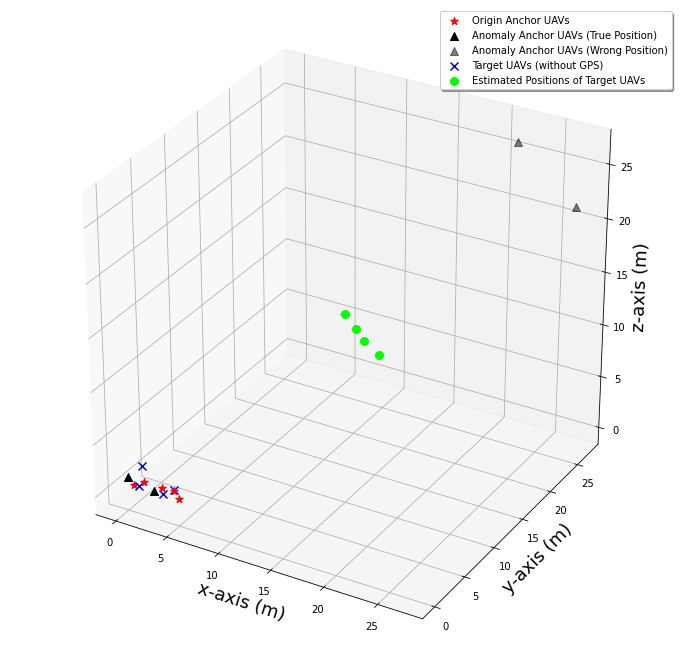

In [234]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
# ax.set_xlim([0, 1300])
# ax.set_ylim([0, 1300])
# ax.set_zlim([0, 1300])
ax.set_xlabel('x-axis (m)', fontsize=18)
ax.set_ylabel('y-axis (m)', fontsize=18)
ax.set_zlabel('z-axis (m)', fontsize=18)
plt.grid()

scatters = []
scattersLegends = []

sample = 21

for originAnchor in OriginAnchors[sample]:
  p = originAnchor.realPosition
  if originAnchor.realPosition == originAnchor.observedPosition:
    scatter1 = ax.scatter(p[0], p[1], p[2], c='#FF0000', marker='*', s=64, alpha=1)
  else:
    scatter_anomaly = ax.scatter(p[0], p[1], p[2], c='#000000', marker='^', s=64, alpha=1)
    scatter_anomalyPosition = ax.scatter(originAnchor.observedPosition[0], originAnchor.observedPosition[1], originAnchor.observedPosition[2], c='#000000', marker='^', s=64, alpha=0.5)
scatters.append(scatter1)
scattersLegends.append("Origin Anchor UAVs")
scatters.append(scatter_anomaly)
scattersLegends.append("Anomaly Anchor UAVs (True Position)")
scatters.append(scatter_anomalyPosition)
scattersLegends.append("Anomaly Anchor UAVs (Wrong Position)")

for originTarget in OriginTargets[sample]:
  p = originTarget.realPosition
  scatter2 = ax.scatter(p[0], p[1], p[2], c='#0000FF', marker='x', s=64, alpha=1)
scatters.append(scatter2)
scattersLegends.append("Target UAVs (without GPS)")

for i, estimatedPosition in enumerate(EstimatedPositionBeforeAnomalyDetection[sample]):
  p = estimatedPosition
  scatter3 = ax.scatter(p[0], p[1], p[2], c='#00FF00', marker='o', s=64, alpha=1)
scatters.append(scatter3)
scattersLegends.append("Estimated Positions of Target UAVs")

plt.legend(scatters, scattersLegends, loc='upper right', shadow=True)
# plt.savefig(rootpath+'/datas/localizationResult/beforeDetection{}_{}_{}.svg'.format(div, pick, model))

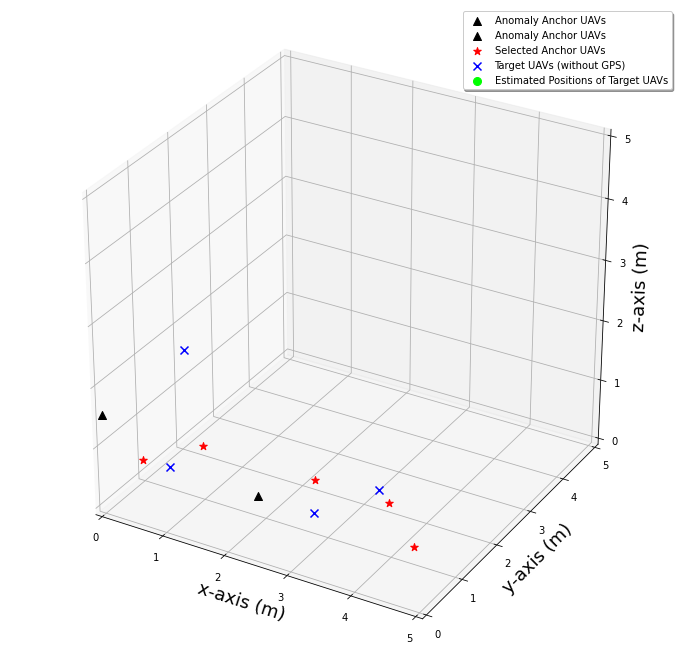

In [235]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.set_xlim([0, 5])
ax.set_ylim([0, 5])
ax.set_zlim([0, 5])
ax.set_xlabel('x-axis (m)', fontsize=18)
ax.set_ylabel('y-axis (m)', fontsize=18)
ax.set_zlabel('z-axis (m)', fontsize=18)
plt.grid()

scatters = []
scattersLegends = []

sample = 21

for originAnchor in SelectedAnchors[sample]:
  p = originAnchor.realPosition
  if originAnchor.realPosition == originAnchor.observedPosition:
    scatter1 = ax.scatter(p[0], p[1], p[2], c='#FF0000', marker='*', s=64, alpha=1)
  else:
    scatter_anomaly = ax.scatter(p[0], p[1], p[2], c='#000000', marker='^', s=64, alpha=1)
    scatters.append(scatter_anomaly)
    scattersLegends.append("Anomaly Anchor UAVs")
scatters.append(scatter1)
scattersLegends.append("Selected Anchor UAVs")

for originTarget in SelectedTargets[sample]:
  p = originTarget.realPosition
  if originTarget.observedPosition == None:
    scatter2 = ax.scatter(p[0], p[1], p[2], c='#0000FF', marker='x', s=64, alpha=1)
  else:
    scatter_anomaly = ax.scatter(p[0], p[1], p[2], c='#000000', marker='x', s=64, alpha=1)
    scatters.append(scatter_anomaly)
    scattersLegends.append("Target UAVs (with Anomalous GPS)")
scatters.append(scatter2)
scattersLegends.append("Target UAVs (without GPS)")

for i, estimatedPosition in enumerate(EstimatedPositionAfterAnomalyDetection[sample]):
  p_bar = SelectedTargets[sample][i].realPosition
  p = estimatedPosition
  # plt.plot([p_bar[0], p[0]], [p_bar[1], p[1]], [p_bar[2], p[2]], c='#000000', linewidth=3.0)
  scatter3 = ax.scatter(p[0], p[1], p[2], c='#00FF00', marker='o', s=64, alpha=1)
scatters.append(scatter3)
scattersLegends.append("Estimated Positions of Target UAVs")

plt.legend(scatters, scattersLegends, loc='upper right', shadow=True)
# plt.savefig(rootpath+'/datas/localizationResult/afterDetection{}_{}_{}.svg'.format(div, pick, model))

In [236]:
import numpy as np
MSE = lambda x,y: np.mean(np.square(np.array(x)-np.array(y)))

In [237]:
Before_Total_sumMSE = []
Before_Total_sumRMSE = []
Before_Each_sumMSE = []
Before_Each_sumRMSE = []
for Sample in range(Samples):
  if Sample == collinearSample:
    continue
  origin_Nngps = len(OriginTargets[Sample])
  origin_Ngps = len(OriginAnchors[Sample])
  sumMSE = []
  sumRMSE = []
  for i in range(origin_Nngps):
    trueP = OriginTargets[Sample][i].realPosition
    estimatedP = EstimatedPositionBeforeAnomalyDetection[Sample][i]
    mse = MSE(trueP, estimatedP)
    rmse = np.sqrt(mse)
    # print("Targets: ", trueP, estimatedP, mse, rmse)
    sumMSE.append(mse)
    sumRMSE.append(rmse)
  for i in range(origin_Ngps):
    trueP = OriginAnchors[Sample][i].realPosition
    estimatedP = OriginAnchors[Sample][i].observedPosition
    mse = MSE(trueP, estimatedP)
    if mse == 0:
      continue
    rmse = np.sqrt(mse)
    # print("Anchors: ", trueP, estimatedP, mse, rmse)
    sumMSE.append(mse)
    sumRMSE.append(rmse)
  Before_Total_sumMSE.append(sum(sumMSE)/env.N)
  Before_Each_sumMSE.append(sumMSE)
  Before_Total_sumRMSE.append(sum(sumRMSE)/env.N)
  Before_Each_sumRMSE.append(sumRMSE)

avg_sumMSE = np.mean(Before_Total_sumMSE)
avg_sumRMSE = np.mean(Before_Total_sumRMSE)
print("Average MSE: {}, RMSE: {}.".format(avg_sumMSE, avg_sumRMSE))

# import os
# try:
#   os.makedirs(rootpath+'/datas/localizationResult')
# except OSError as error:
#   print(error)

# np.save(rootpath+'/datas/localizationResult/before_localization_avgMSE{}_{}_{}'.format(div, pick, model), avg_sumMSE)
# np.save(rootpath+'/datas/localizationResult/before_localization_avgRMSE{}_{}_{}'.format(div, pick, model), avg_sumRMSE)
# f = open(rootpath+'/datas/localizationResult/0804_before_localization_avgRMSE{}_{}_{}.pkl'.format(div, pick, model), "wb")
# pickle.dump(avg_sumRMSE, f)
# f.close()

# np.save(rootpath+'/datas/localizationResult/before_localization_MSE{}_{}_{}'.format(div, pick, model), Before_Each_sumMSE)
# np.save(rootpath+'/datas/localizationResult/before_localization_RMSE{}_{}_{}'.format(div, pick, model), Before_Each_sumRMSE)

# f = open(rootpath+'/datas/localizationResult/before_localization_MSE{}_{}_{}.pkl'.format(div, pick, model), "wb")
# pickle.dump(Before_Each_sumMSE, f)
# f.close()

f = open(rootpath+'/datas/localizationResult/0906_before_localization_realDataRMSE_{}_{}.pkl'.format(pick, model), "wb")
pickle.dump(Before_Each_sumRMSE, f)
f.close()

Average MSE: 226.07385200707083, RMSE: 10.575838852335126.


[[13.426952851739038, 13.620641779319092, 13.033778028710836, 13.605655628127877, 22.86854163264145, 24.453911331997713], [27.988659190511534, 32.61379167520379, 20.753374090089444, 19.88056651637987, 24.424369422526862, 23.685876220410155], [15.530974156954493, 17.10052574540689, 17.690079240748798, 16.232493268335656, 25.08386124738702, 24.17348441549442], [14.579690638513197, 15.25273060029694, 13.185708346893843, 13.720985760392903, 23.928320176940495, 24.159160439055004], [12.642854803297334, 12.64145333152523, 12.735996154461859, 12.506071389592005, 23.198532450535023, 22.179996491630046], [12.286632166553368, 13.805439286882729, 14.423506830851295, 14.085696621831191, 26.097786668425414, 23.913211597847894], [20.01047753764619, 16.72934725776191, 17.041570849307497, 16.166573531179036, 26.117763797480528, 25.174871319489295], [20.498872809623517, 22.32014150074034, 15.252930080732526, 14.498574834461126, 23.347912251668482, 24.0402110048825], [15.57987356357575, 14.7002882709124

Text(0.5, 0, 'Localization Error')

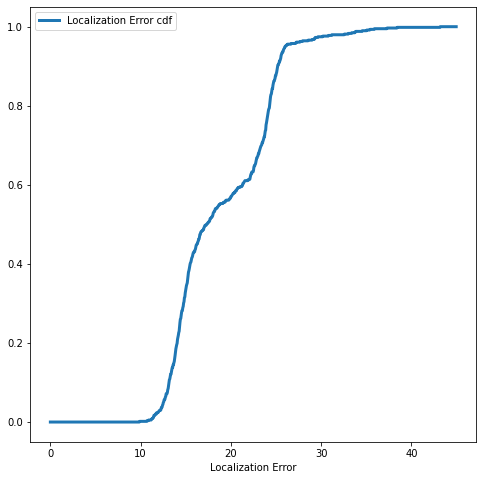

In [238]:
print(Before_Each_sumRMSE)
# print(np.array(Before_Each_sumMSE).flatten().tolist())
Before_sumRMSE = np.concatenate(([], np.array(Before_Each_sumRMSE).flatten().tolist()),axis=0)
# Before_sumRMSE = [np.log(y) for y in Before_sumRMSE]
print(Before_sumRMSE)
Before_RMSEHist, Before_bin_edges = np.histogram(Before_sumRMSE, bins=1000, range=(0, 0.045*1e3), density=True)
normalizeBefore_RMSEHist = Before_RMSEHist*np.diff(Before_bin_edges)

Before_cdf=np.cumsum(normalizeBefore_RMSEHist)

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(1,1, figsize = (8,8))
ax1.plot(Before_bin_edges[:-1], Before_cdf, label = 'Localization Error cdf', linewidth=3.0)
# ax1.hist(Before_sumMSE, bins = 1000, label = 'Localization Error cdf', range=(0, 1.0*1e6), alpha = 0.5, cumulative=True, density=True)
ax1.legend()
ax1.set_xlabel('Localization Error')

In [239]:
After_Total_sumMSE = []
After_Total_sumRMSE = []
After_Each_sumMSE = []
After_Each_sumRMSE = []
for Sample in range(Samples):
  if Sample == collinearSample:
    continue
  new_Nngps = len(SelectedTargets[Sample])
  new_Ngps = len(SelectedAnchors[Sample])
  sumMSE = []
  sumRMSE = []
  for i in range(new_Nngps):
    trueP = SelectedTargets[Sample][i].realPosition
    estimatedP = EstimatedPositionAfterAnomalyDetection[Sample][i]
    mse = MSE(trueP, estimatedP)
    rmse = np.sqrt(mse)
    # print("Targets: ", trueP, estimatedP, mse, rmse)
    sumMSE.append(mse)
    sumRMSE.append(rmse)
  for i in range(new_Ngps):
    trueP = SelectedAnchors[Sample][i].realPosition
    estimatedP = SelectedAnchors[Sample][i].observedPosition
    mse = MSE(trueP, estimatedP)
    if mse == 0:
      continue
    rmse = np.sqrt(mse)
    # print("Anchors: ", trueP, estimatedP, mse, rmse)
    sumMSE.append(mse)
    sumRMSE.append(rmse)
  After_Total_sumMSE.append(sum(sumMSE)/env.N)
  # After_Total_sumMSE.append(np.mean(sumMSE))
  After_Each_sumMSE.append(sumMSE)
  After_Total_sumRMSE.append(sum(sumRMSE)/env.N)
  # After_Total_sumRMSE.append(np.mean(sumRMSE))
  After_Each_sumRMSE.append(sumRMSE)

avg_sumMSE = np.mean(After_Total_sumMSE)
avg_sumRMSE = np.mean(After_Total_sumRMSE)
print("Average MSE: {}, RMSE: {}.".format(avg_sumMSE, avg_sumRMSE))

# try:
#   os.makedirs(rootpath+'/datas/localizationResult')
# except OSError as error:
#   print(error)


# np.save(rootpath+'/datas/localizationResult/after_localization_MSE{}_{}_{}'.format(div, pick, model), avg_sumMSE)
# np.save(rootpath+'/datas/localizationResult/after_localization_avgRMSE{}_{}_{}'.format(div, pick, model), avg_sumRMSE)
# f = open(rootpath+'/datas/localizationResult/0804_after_localization_avgRMSE{}_{}_{}.pkl'.format(div, pick, model), "wb")
# pickle.dump(avg_sumRMSE, f)
# f.close()

# np.save(rootpath+'/datas/localizationResult/after_localization_MSE{}_{}_{}'.format(div, pick, model), After_Each_sumMSE)
# np.save(rootpath+'/datas/localizationResult/after_localization_RMSE{}_{}_{}'.format(div, pick, model), After_Each_sumRMSE)

# f = open(rootpath+'/datas/localizationResult/after_localization_MSE{}_{}_{}.pkl'.format(div, pick, model), "wb")
# pickle.dump(After_Each_sumMSE, f)
# f.close()

f = open(rootpath+'/datas/localizationResult/0906_after_localization_realDataRMSE_{}_{}.pkl'.format(pick, model), "wb")
pickle.dump(After_Each_sumRMSE, f)
f.close()

Average MSE: 52.68078138345777, RMSE: 3.596652667519336.


[[12.282033072080543, 11.251885482604802, 11.021381734991548, 10.831213804487662, 11.171368597211725, 22.86854163264145], [20.08365885104932, 18.47561823987288, 18.07270001835078, 20.268676642440617, 17.573165385019394, 23.685876220410155], [2.7791713018340527, 2.8628361278853913, 3.0769280137156856, 3.4810110504859195, 3.4973048741915655, 4.176758561965098], [1.5172096382888127, 1.0708924873673626, 1.543470679879182, 1.5561578914246654, 1.8252208236612013, 2.4422876940517457], [1.0118635283841468, 0.7392234799058459, 1.0782922895539673, 1.1835225836104408, 0.7955507741447637, 1.3032318090513941], [0.8454425964854433, 1.5646505538565931, 1.839467676641231, 0.8701741428062031, 0.9067521423515648, 1.6272031723139437], [1.223803285608575, 0.8449821063865011, 0.5078200228710972, 0.36640705076488367, 1.0334186933609035, 1.1007428838280922], [1.31434499277487, 0.8427926640886082, 1.0907773509907817, 1.1074735168743723, 1.4544445432232522, 1.5212376653638815], [3.8227702344993157, 2.924392539

Text(0.5, 0, 'Localization Error')

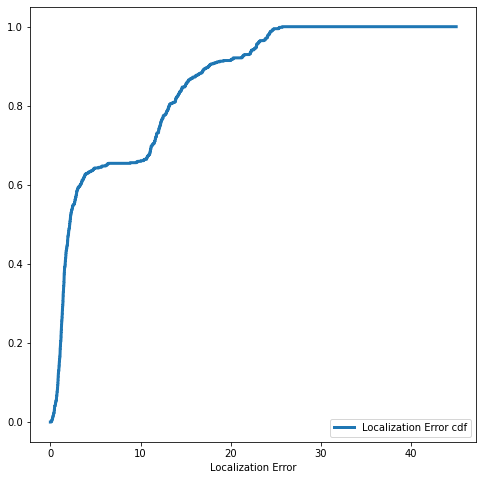

In [240]:
# After_Each_sumRMSE = np.load(rootpath+'/datas/localizationResult/after_localization_RMSE{}_{}_{}.npy'.format(div, pick, model), allow_pickle=True)
print(After_Each_sumRMSE)
from functools import reduce
from operator import add
After_sumRMSE = reduce(add ,After_Each_sumRMSE)
# print(np.array(After_Each_sumMSE).reshape(-1))
# After_sumMSE = np.concatenate(([], np.array(After_Each_sumMSE).flatten().tolist()),axis=0)
# After_sumRMSE = [np.log(y) for y in After_sumRMSE]
print(After_sumRMSE)
After_RMSEHist, After_bin_edges = np.histogram(After_sumRMSE, bins=50000, range=(0, 0.045*1e3), density=True)
normalizeAfter_RMSEHist = After_RMSEHist*np.diff(After_bin_edges)

After_cdf=np.cumsum(normalizeAfter_RMSEHist)

import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(1,1, figsize = (8,8))
ax1.plot(After_bin_edges[:-1], After_cdf, label = 'Localization Error cdf', linewidth=3.0)
# ax1.hist(After_sumMSE, bins = 10000, label = 'Localization Error cdf', alpha = 0.5, range=(0, 0.06*1e6), cumulative=True, density=True)
ax1.legend(loc='lower right')
ax1.set_xlabel('Localization Error')

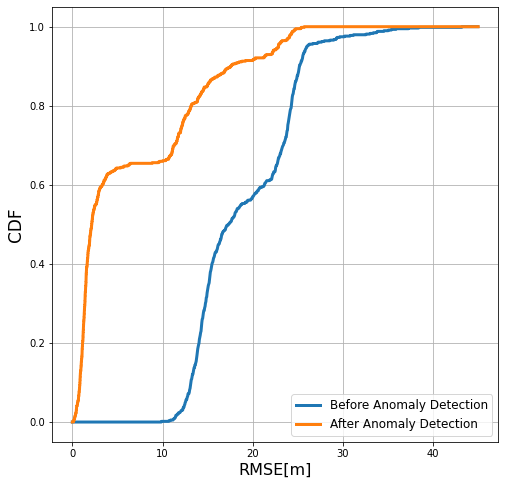

In [241]:
fig, ax1 = plt.subplots(1,1, figsize = (8,8))
plt.grid()
ax1.ticklabel_format(style='sci', scilimits=(-1,2), axis='x')
ax1.plot(Before_bin_edges[:-1], Before_cdf, label = 'Before Anomaly Detection', linewidth=3.0)
ax1.plot(After_bin_edges[:-1], After_cdf, label = 'After Anomaly Detection', linewidth=3.0)
# ax1.hist(Before_sumMSE, bins = 1000, label = 'Localization Error cdf', range=(0, 1.0*1e6), alpha = 0.5, cumulative=True, density=True)
ax1.legend(loc='lower right', prop={'size': 12})
ax1.set_xlabel('RMSE[m]', fontsize=16)
ax1.set_ylabel('CDF', fontsize=17)
# plt.savefig("Log-RMSE.svg")
plt.savefig(rootpath+'/datas/localizationResult/realDataRMSE_{}_{}.png'.format(pick, model))

### Localization Result with The **Absence** of Anomaly Detection in One Anomalous UAV Condition
Average MSE: 142.45949591258818, RMSE: 7.772324596791224.

### Localization Result with The **Absence** of Anomaly Detection in Two Anomalous UAVs Condition
Average MSE: 230.49530974113796, RMSE: 10.630885344957855.

### Localization Result with The **Presence** of Anomaly Detection in One Anomalous UAV Condition
Average MSE: 15.63693278695681, RMSE: 1.6260984281115196.

### Localization Result with The **Presence** of Anomaly Detection in Two Anomalous UAVs Condition
Average MSE: 53.419297909866216, RMSE: 3.6477724121792594.

Average MSE: 142.66957353915342, RMSE: 7.778407875557363.

Average MSE: 33.99100064723042, RMSE: 3.545695303819724.

Average MSE: 230.96572176291045, RMSE: 10.640451686555705.

Average MSE: 94.56725456768956, RMSE: 6.520866316820139.

In [246]:
((142.66957353915342-33.99100064723042)/142.66957353915342)*100

76.17501769716714

In [247]:
((230.96572176291045-94.56725456768956)/230.96572176291045)*100

59.05571881148486

Average MSE: 142.66957353915342, RMSE: 7.778407875557363.

Average MSE: 15.784811355854712, RMSE: 1.635887809486027.

Average MSE: 230.96572176291045, RMSE: 10.640451686555705.

Average MSE: 52.1010633474844, RMSE: 3.586802259506616.

In [244]:
((142.66957353915342-15.784811355854712)/142.66957353915342)*100

88.9361053206465

In [245]:
((230.96572176291045-52.1010633474844)/230.96572176291045)*100

77.44207973814969